In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import PlaceCellAnalysis as pc
import pickle

os.sys.path.append('../')
import utilities as u
import preprocessing as pp
import matplotlib.gridspec as gridspec
import SimilarityMatrixAnalysis as sm


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [262]:
mouse = '4222153.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1727,4222153.2,08_04_2019,1,TwoTower_foraging,86,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222153.2\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...
1751,4222153.2,10_04_2019,3,TwoTower_foraging,80,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.2\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...
1771,4222153.2,12_04_2019,2,TwoTower_foraging,86,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222153.2\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...
1788,4222153.2,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222153.2\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...
1800,4222153.2,15_04_2019,2,TwoTower_foraging,103,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.2\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...
1816,4222153.2,16_04_2019,2,TwoTower_foraging,98,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222153.2\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...
1825,4222153.2,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222153.2\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...
1833,4222153.2,18_04_2019,3,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222153.2\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...


In [263]:
sess = df_mouse.iloc[-3]

In [264]:
VRDat,C, S, A = pp.load_scan_sess(sess)

num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [265]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['wallJitter']+trial_info['towerJitter']
effMorph = (effMorph+.25)/1.5

In [266]:
S_trial_mat[np.isnan(S_trial_mat)]=0
S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,1,axis=1)
S_tmat = np.reshape(S_trial_mat,[S_trial_mat.shape[0],-1])
S_tmat = S_tmat/np.linalg.norm(S_tmat,ord=2,axis=-1)[:,np.newaxis]
S_t_rmat = np.matmul(S_tmat,S_tmat.T)

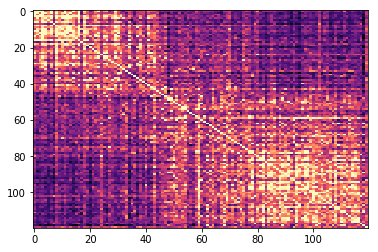

In [267]:
msort = np.argsort(effMorph)
C_msort = sm._sort_simmat(S_t_rmat,msort)
f,ax = plt.subplots()
ax.imshow(C_msort,aspect='auto',cmap='magma',vmax = np.percentile(C_msort,95))

3.391835439269429
2.1892550468520313
1.6546520012400776
1.78881599727514
1.6065351661596075
1.7407982857197666
1.5441831116750424
1.4630717043494923
3.391835439269429
2.1892550468520313
1.6546520012400776
1.670716018071926
1.5523160692900033
1.5711442329770275
1.5037257421697845
1.3029264999841144
2


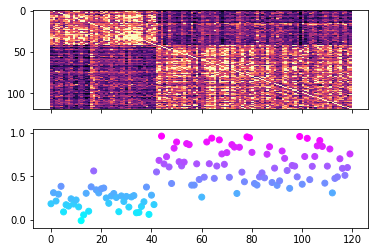

In [268]:
_labels = sm.cluster_simmat(S_t_rmat)
nc = np.unique(_labels).shape[0]
clustmean = np.array([effMorph[_labels==i].mean() for i in range(nc)])
clusterOrder = np.argsort(clustmean)
labels = np.zeros(effMorph.shape)

for i,cl in enumerate(clusterOrder.tolist()):
    labels[_labels==cl]=i
#print(clusterOrder)

clustsort = sm._sort_clusters(sm.cluster_simmat(S_t_rmat),effMorph)
C_csort = sm._sort_simmat(S_t_rmat,clustsort)
print(nc)

f,ax = plt.subplots(2,1,sharex=True)
ax[0].imshow(C_csort,aspect='auto',cmap='magma',vmax = np.percentile(C_msort,95),vmin=0.1)
ax[1].scatter(np.arange(effMorph.shape[0]),effMorph[clustsort],c=effMorph[clustsort],cmap='cool')

In [269]:
# get center at morph == 0
centroid_0 = sp.ndimage.filters.gaussian_filter1d(S_trial_mat[trial_info['morphs']==0,:,:].mean(axis=0),2,axis=0)
centroid_0/=np.linalg.norm(centroid_0,2,axis=-1)[:,np.newaxis]

# get center at morph == 1
centroid_1 = sp.ndimage.filters.gaussian_filter1d(S_trial_mat[trial_info['morphs']==1,:,:].mean(axis=0),2,axis=0)
centroid_1/=np.linalg.norm(centroid_1,2,axis=-1)[:,np.newaxis]

print(centroid_0.shape,np.dot(centroid_0.ravel(),centroid_0.ravel()))


(45, 2149) 45.0


In [270]:
pos_dig = np.digitize(VRDat.pos._values,edges,right=True)
print(np.amin(pos_dig),np.amax(pos_dig),len(edges))
pos_dig-=1
pos_dig[VRDat.pos._values>edges[-1]]=-1
print(np.amin(pos_dig),np.amax(pos_dig),len(edges))
# at each time point
angles = np.zeros([S.shape[0],2])
Ssm = sp.ndimage.filters.gaussian_filter1d(S,5,axis=0)
Ssmn=Ssm/np.linalg.norm(Ssm,2,axis=1)[:,np.newaxis]
for t in range(S.shape[0]):
    # get angle between pop activity and centroid vectors
    angles[t,0] = np.dot(centroid_0[pos_dig[t],:],S[t,:])
    angles[t,1] = np.dot(centroid_1[pos_dig[t],:],S[t,:])


# take log ratio of angles
lr = np.log(angles[:,1])-np.log(angles[:,0])

0 46 46
-1 44 46


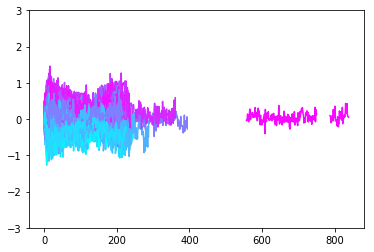

In [271]:
f,ax = plt.subplots()
ax.set_ylim([-3,3])
for t, (start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
#     print(start,stop)
    
    ax.plot(np.arange(stop-start),lr[start:stop],c=plt.cm.cool(effMorph[t]))
#     ax.set_title("%f" % effMorph[t])
   

In [272]:
lr_bin = np.zeros(S_trial_mat.shape[:-1])
S_tmat_norm = S_trial_mat/np.linalg.norm(S_trial_mat,2,axis=-1)[:,:,np.newaxis]
for trial in range(S_trial_mat.shape[0]):
    angle0 = np.diagonal(np.matmul(S_trial_mat[trial,:,:],centroid_0.T))
    angle1 = np.diagonal(np.matmul(S_trial_mat[trial,:,:],centroid_1.T))
    lr_bin[trial,:]=np.log(angle1/angle0)
    

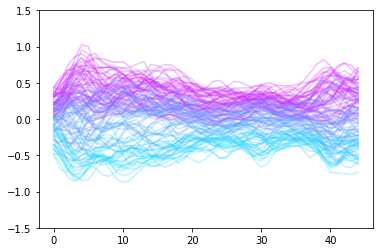

In [273]:
f,ax = plt.subplots()
ax.set_ylim([-1.5,1.5])
for t in range(lr_bin.shape[0]):    
    ax.plot(lr_bin[t,:],c=plt.cm.cool(effMorph[t]),alpha=.3)

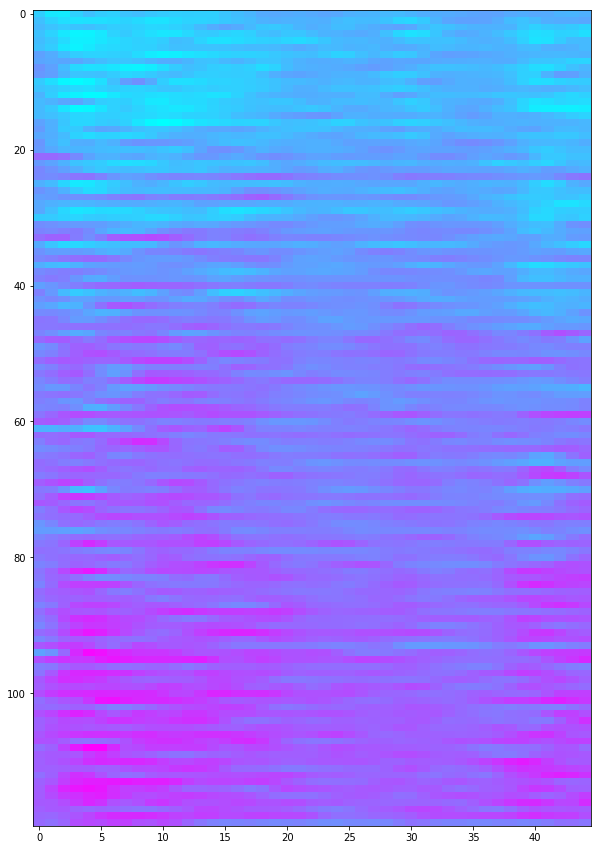

In [274]:
f,ax = plt.subplots(figsize=[10,15])
ax.imshow(lr_bin[np.argsort(effMorph),:],aspect='auto',cmap='cool')

In [107]:
# add cross-validation